In [1]:
import os
import pandas as pd
import numpy as np
import sklearn.metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import _gradient_boosting
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from helper_functions_pipe_testing import *
from sklearn.metrics import  f1_score, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import *
from sklearn.preprocessing import LabelEncoder
from helper_functions_KP import *
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

#Instructions for the pipeline Requires two inputs for training: - Mass spec data with corresponding NP surface characteristics and experimental conditions (time, concentration) - NetsurfP and Biopython data that has been precalculated - X characteristics to predict
pipeline Take mass spec spreadsheet Accession,Enrichment,Dh,TEM,Zp,BET,Composition,Ligand,Shape,IncubationTime,IncubationConcentration Merge with Proteome data to get file that has Accession,Enrichment,Dh,TEM,Zp,BET,Composition,Ligand,Shape,IncubationTime,IncubationConcentration,Mass,Length,Sequence Calculate protein features using biopython Merge with NSP data to get all protein features
Split into X and Y dataset with Entries as labels

In [3]:
all_file='Input_data/Proteomic data/abundance/Norm_Intensity_Bovsynth022123.xlsx'
raw_MS_data=pd.read_excel(all_file,header=0)
col_length=raw_MS_data.shape[0]
to_drop=[]
for i in raw_MS_data.columns:
    column=raw_MS_data[i]
    zeros=(column==0).sum()
    # print(zeros)
    # print(zeros)
    # print(raw_MS_data[i])
    if zeros>int(col_length/2):
        to_drop.append(i)
        # print(raw_MS_data.shape[1])
# print(raw_MS_data.shape[1])
print(to_drop)
raw_MS_data.drop(columns=to_drop,inplace=True)

[31, 32, 33, 34, 35, 36, 37, 38, 44, 45, 46, 47, 48, 49, 50, 'Unnamed: 26']


In [3]:
# Pull together Proteomic data
in_dir="Input_data/Proteomic data/abundance/"
all_file='Input_data/Proteomic data/abundance/Intensity _all20230202.xlsx'
#combine Mass Spec data input into one excel spreadsheet - Entry - Abundance labeled by NP Unique ID
#Abundance as a percent
#take files in_dir and combine then into one pandas df (raw_MS_data)
# files = os.listdir(in_dir)
# for i,f in enumerate(files):
#     if i==0:
#         raw_MS_data=pd.read_excel(in_dir+f,header=0)
#     else:
#         temp = pd.read_excel(in_dir+f,header=0)
#         raw_MS_data=raw_MS_data.merge(temp,how='outer',on='Entry')
raw_MS_data=pd.read_excel(all_file,header=0)
#drop samples that are missing more than half of the proteins in their file, dont use this section currently
# col_length=raw_MS_data.shape[0]
# to_drop=[]
# for i in raw_MS_data.columns:
#     column=raw_MS_data[i]
#     zeros=(column==0).sum()
#     if zeros>int(col_length/2):
#         to_drop.append(i)
# raw_MS_data.drop(columns=to_drop,inplace=True)
# melt the df to make it an accession number, NPUNID, Abundance dataset
raw_MS_data = pd.melt(raw_MS_data, id_vars=['Entry'],var_name='Sample_num', value_name='Abundance')
#remove prots that were added due to merge
raw_MS_data=raw_MS_data.dropna()
###Bring in controls (MS data for serums)##
controls=pd.read_excel('Input_data/Proteomic data/controls_combined.xlsx',header=0)
MS_data_controls = pd.merge(raw_MS_data,controls,how='left', on='Entry')
###Bring in Uniprot_data,NSPdata and NP data##
uniprot_filepath='Input_data/BioPython_data/Combined_biopyCalcs.xlsx'
uniprot_dat=pd.read_excel(uniprot_filepath,header=0)
NSPfilePath='Input_data/NetSurfP_data/Combined.xlsx'
NSP_data=pd.read_excel(NSPfilePath)
###Bring in NP data and merge to get complete NP dataset###
NP_filepath='Input_data/NPs/NP_Database.xlsx'
NPUNdata=pd.read_excel(NP_filepath,header=0,sheet_name='NPUNID')
NPprop=pd.read_excel(NP_filepath,header=0,sheet_name='NP_Props')
NPdata=pd.merge(NPUNdata,NPprop,how="left",on='NPID')
NPdata.dropna(inplace=True)
#calculate Enrichment
#####MAYBE add binning here to keep negative results and improve capapbilities######
MS_data_controls['Enrichment']= np.log2(MS_data_controls['Abundance']/MS_data_controls['Abundance_Controls'])
# MS_data=MS_data_controls.drop(columns=['Abundance','Abundance_Controls'])
#keep abundance Controls
# MS_data=MS_data_controls.drop(columns=['Abundance'])
raw_prop_data=pd.merge(MS_data_controls, uniprot_dat.drop_duplicates(subset=['Entry']), how='left',on='Entry')
Protein_data_complete = pd.merge(raw_prop_data, NSP_data.drop_duplicates(subset=['Entry']),how='left', on='Entry') #merges netsurfp features and biopython features
Protein_data_complete.fillna(0,inplace=True)
#creates new column called asa_sum_normalized which is the asa_sum value divide by the mass of the protein
for df in [Protein_data_complete]:
    for col in ['asa_sum']:
        df[col+'_normalized'] = df[col] / df['Mass']

data_complete= pd.merge(Protein_data_complete,NPdata,how='inner', on='Sample_num')
data_complete.drop(columns=['notes','Notes','NPUNID'],inplace=True)
data_complete.fillna(0,inplace=True)
data_complete= data_complete.replace([-np.inf],'-12')
data_complete=data_complete.replace([np.inf],'12')
#create ordinal variables
# data_complete2=pd.get_dummies(data_complete, columns=['Core Material','Surface_Ligand'])
le=LabelEncoder()
data_complete['Core Material']=le.fit_transform(data_complete['Core Material'])
data_complete['Surface_Ligand']=le.fit_transform(data_complete['Surface_Ligand'])

#set labels (what we are trying to predict) as Enrichment column
# labels=data_complete['Enrichment'].copy()
label_abund=np.ravel(data_complete['Abundance'].copy())
label_enrich=np.ravel(data_complete['Enrichment'].copy())
#make it one dimenisional
#drop qualitative, not neccessary, and label columns
#create df without bonus NSP columns (remove total_exposed)
to_drop=data_complete.filter(like='total_exposed_')
data_complete.drop(columns=to_drop,inplace=True)
df=data_complete.drop(['Entry','Abundance','Sequence','NPID','Enrichment','Ligands','Protein Source','Sample_num','Unnamed: 5','Raw_FileID'],axis=1)
# df_enrich=data_complete.drop(['Entry','Abundance','Sequence','NPID','Ligands','Protein Source','Sample_num','Unnamed: 5','Raw_FileID'],axis=1)


C:\Users\pouls\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


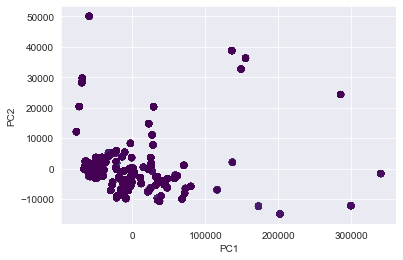

In [9]:
#Run PCA to seee how data differentiates#
from sklearn.decomposition import PCA
pca= PCA(n_components=2)
x_pca=pca.fit_transform(df)

plt.scatter(x_pca[:, 0], x_pca[:, 1], c=label_abund, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [22]:
#Remove correlated features (over r2 threshold level) and output reduced dataframe (df2)#
corr_matrix = df.corr()
threshold = 0.8
correlated_features = set()

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if threshold < abs(corr_matrix.iloc[i, j]) < 1:
            colname = corr_matrix.columns[i]
            correlated_features.add(colname)
correlated_features
df_2=df.drop(columns=correlated_features)

{'Ligand_BSA',
 'Ligand_Citrate',
 'Ligand_PEI',
 'Mass',
 'NP_incubation Concentration (mg/mL)',
 'Surface_Ligand',
 'asa_sum',
 'flexibility_max',
 'flexibility_median',
 'flexibility_min',
 'flexibility_std',
 'flexibility_var',
 'fraction_buried',
 'fraction_exposed_exposed_G',
 'fraction_exposed_exposed_H',
 'fraction_exposed_exposed_K',
 'fraction_exposed_exposed_N',
 'fraction_exposed_exposed_P',
 'fraction_exposed_exposed_R',
 'fraction_exposed_nonpolar_exposed',
 'fraction_exposed_nonpolar_total',
 'fraction_exposed_polar_exposed',
 'fraction_exposed_polar_total',
 'molecular_weight',
 'nsp_disordered',
 'nsp_secondary_structure_helix',
 'rsa_mean',
 'rsa_median',
 'secondary_structure_fraction_sheet',
 'secondary_structure_fraction_turn'}

In [ ]:
#run Recursive feature elimination with cross validation
from sklearn.model_selection import KFold
step=1
min_feats=10
cv= KFold(n_splits=10)
estimator=RandomForestRegressor(n_estimators=100)
# estimator=Lasso(alpha=.05)
selector = RFECV(estimator=estimator, cv=cv, scoring='neg_mean_squared_error', min_features_to_select=min_feats, step=step)
selector = selector.fit(df_2, label_abund)
selector.support_
feat_list2 = selector.get_feature_names_out()

In [12]:
#use recursive feature elimination with Random Forest Regression as the estimator to select top 45 important features
step=3
feats=45
estimator=RandomForestRegressor(n_estimators=100)
selector = RFE(estimator, n_features_to_select=feats, step=step)
selector = selector.fit(df, label_abund)
selector.support_
feat_list = selector.get_feature_names_out()

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

# Load the breast cancer dataset


# Split the data into features and target
X = df
y = label_abund

# Standardize the data
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Apply Lasso regularization for feature selection
lasso = Lasso(alpha=0.1, max_iter=10000)
lasso.fit(X_std, y)

# Print the selected features based on the estimated coefficients
selected_features = df.columns[lasso.coef_ != 0]
print('Selected features:', selected_features)


Selected features: Index(['Abundance_Controls', 'Mass', 'molecular_weight',
       'fraction_exposed_exposed_M', 'fraction_exposed_exposed_N',
       'fraction_exposed_exposed_V', 'nsp_secondary_structure_coil'],
      dtype='object')


In [13]:
df_rfe=df[feat_list]
feat_list

array(['Abundance_Controls', 'Length', 'frac_aa_A', 'frac_aa_C',
       'frac_aa_D', 'frac_aa_E', 'frac_aa_F', 'frac_aa_H', 'frac_aa_I',
       'frac_aa_K', 'frac_aa_N', 'frac_aa_Q', 'frac_aa_R', 'frac_aa_T',
       'frac_aa_V', 'molecular_weight', 'flexibility_max',
       'flexibility_min', 'secondary_structure_fraction_sheet',
       'secondary_structure_fraction_disordered', 'asa_sum',
       'fraction_exposed_exposed_E', 'fraction_exposed_exposed_G',
       'fraction_exposed_exposed_H', 'fraction_exposed_exposed_I',
       'fraction_exposed_exposed_K', 'fraction_exposed_exposed_N',
       'fraction_exposed_exposed_P', 'fraction_exposed_exposed_V',
       'nsp_secondary_structure_coil', 'nsp_secondary_structure_helix',
       'nsp_disordered', 'BatchID', 'Zeta Potential', 'Core Material',
       'Ligand_BSA', 'Ligand_PEG', 'Surface_Ligand', 'Dtem', 'Dh_core',
       'Dh_functionalized', 'Centrifuged',
       'NP_incubation Concentration (mg/mL)',
       'Incubation Concentration (m

In [24]:
from sklearn.model_selection import KFold
step=1
min_feats=3
cv= KFold(n_splits=10)
# estimator=RandomForestRegressor(n_estimators=100)
estimator=Lasso(alpha=.05)
selector = RFECV(estimator=estimator, cv=cv, scoring='neg_mean_squared_error', min_features_to_select=min_feats, step=step)
selector = selector.fit(df_rfe, label_abund)
selector.support_
feat_list2 = selector.get_feature_names_out()

C:\Users\pouls\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.472e+03, tolerance: 2.942e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\pouls\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.472e+03, tolerance: 2.942e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\pouls\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.472e+03, toleranc

In [25]:
feat_list2

array(['Abundance_Controls', 'Length', 'molecular_weight', 'asa_sum',
       'fraction_exposed_exposed_I', 'fraction_exposed_exposed_K',
       'fraction_exposed_exposed_N', 'fraction_exposed_exposed_P',
       'fraction_exposed_exposed_V', 'nsp_secondary_structure_coil'],
      dtype=object)

In [22]:
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
import numpy as np


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_rfe, label_abund, test_size=0.2, random_state=42)

# Create the base models
rf = RandomForestRegressor(n_estimators=100, random_state=42)
ridge = Ridge(alpha=0.1, random_state=42)

rf_model = rf.fit(X_train,y_train)
ridge_model = ridge.fit(X_train,y_train)
# Make predictions with the base models
rf_pred = cross_val_predict(rf_model, X_train, y_train, cv=5)
ridge_pred = cross_val_predict(ridge_model, X_train, y_train, cv=5)

# Create the input for the meta-model
stacking_input = np.column_stack((rf_pred, ridge_pred))

# Train the meta-model (ridge regression)
meta_model = Ridge(alpha=1.0, random_state=42)
meta_model.fit(stacking_input, y_train)

# Make predictions with the meta-model
rf_pred_test = rf_model.predict(X_test)
ridge_pred_test = ridge_model.predict(X_test)
stacking_input_test = np.column_stack((rf_pred_test, ridge_pred_test))
y_pred_test = meta_model.predict(stacking_input_test)

# Evaluate the performance of the stacked model
mse = mean_squared_error(y_test, y_pred_test)
print("MSE: {:.2f}".format(mse))


MSE: 0.66


In [23]:
rf.score(X_test,y_test)

0.8686505171967944

In [21]:
ridge.feature_names_in_

array(['Abundance_Controls', 'Length', 'Mass', 'frac_aa_A', 'frac_aa_C',
       'frac_aa_D', 'frac_aa_E', 'frac_aa_F', 'frac_aa_G', 'frac_aa_H',
       'frac_aa_I', 'frac_aa_K', 'frac_aa_L', 'frac_aa_M', 'frac_aa_N',
       'frac_aa_P', 'frac_aa_Q', 'frac_aa_R', 'frac_aa_S', 'frac_aa_T',
       'frac_aa_V', 'frac_aa_W', 'frac_aa_Y', 'molecular_weight',
       'aromaticity', 'instability_index', 'flexibility_mean',
       'flexibility_std', 'flexibility_var', 'flexibility_max',
       'flexibility_min', 'flexibility_median', 'isoelectric_point',
       'secondary_structure_fraction_helix',
       'secondary_structure_fraction_turn',
       'secondary_structure_fraction_sheet',
       'secondary_structure_fraction_disordered', 'gravy',
       'fraction_exposed', 'fraction_buried',
       'fraction_exposed_nonpolar_total',
       'fraction_exposed_nonpolar_exposed',
       'fraction_exposed_polar_total', 'fraction_exposed_polar_exposed',
       'rsa_mean', 'rsa_median', 'rsa_std', 'asa_su

In [38]:
feat_list2

array(['Abundance_Controls', 'Length', 'frac_aa_C', 'frac_aa_E',
       'frac_aa_F', 'frac_aa_H', 'frac_aa_I', 'frac_aa_N', 'frac_aa_Q',
       'frac_aa_R', 'molecular_weight', 'aromaticity', 'flexibility_min',
       'secondary_structure_fraction_sheet',
       'fraction_exposed_nonpolar_exposed', 'asa_sum',
       'fraction_exposed_exposed_A', 'fraction_exposed_exposed_E',
       'fraction_exposed_exposed_G', 'fraction_exposed_exposed_H',
       'fraction_exposed_exposed_I', 'fraction_exposed_exposed_K',
       'fraction_exposed_exposed_M', 'fraction_exposed_exposed_N',
       'fraction_exposed_exposed_P', 'fraction_exposed_exposed_S',
       'fraction_exposed_exposed_T', 'nsp_secondary_structure_coil',
       'nsp_secondary_structure_helix', 'nsp_disordered', 'BatchID',
       'Zeta Potential', 'Core Material', 'Ligand_BSA', 'Ligand_PEG',
       'Surface_Ligand', 'Dtem', 'Dh_core', 'Dh_functionalized',
       'Centrifuged', 'NP_incubation Concentration (mg/mL)',
       'Incubation C

C:\Users\kmp95\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


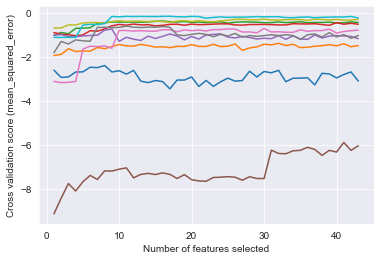

In [39]:
selected_features= df_rfe.columns[selector.support_]
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (mean_squared_error)")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.show()


In [40]:
selector.grid_scores_

C:\Users\kmp95\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


array([[-2.60030016, -1.93596589, -1.02126055, -0.89227121, -1.01507047,
        -9.1308593 , -3.10905289, -1.80753778, -0.68736061, -1.10931217],
       [-2.92901169, -1.88038321, -0.88602322, -0.96535971, -0.98001887,
        -8.41760676, -3.16531769, -1.29672523, -0.68356828, -1.11466883],
       [-2.9093856 , -1.62947992, -0.9476709 , -0.98993623, -1.0724306 ,
        -7.74825778, -3.15157798, -1.40796396, -0.54482115, -1.10875676],
       [-2.68332418, -1.75375132, -0.70176964, -1.03346294, -1.07666703,
        -8.09030382, -3.11466261, -1.22534709, -0.54778831, -1.11308942],
       [-2.67740514, -1.72685225, -0.69017592, -0.99793944, -1.04661811,
        -7.67101286, -1.64068486, -1.2670239 , -0.45634029, -0.55384789],
       [-2.46763567, -1.73558028, -0.67289877, -0.80925621, -1.02621286,
        -7.38020268, -1.51150113, -1.28678443, -0.4355193 , -0.5166977 ],
       [-2.48468246, -1.57024731, -0.46002976, -0.83167248, -1.01142117,
        -7.56708711, -1.52995787, -0.65596157

In [122]:
# df_NSP_drop2=feat_elim_rand(df_NSP_drop,labels,'nspdrop',15,250,3)

In [127]:
df_list=[df,df]
labels=[label_enrich,label_abund]
out_name=['enrich','abund']
df_listnew=[]
x=0
for i in df_list:
    df_listnew.append(feat_elim_rand(i,labels[x],out_name[x],15,150,3))
    x+=1

In [130]:
df_enrich=df_listnew[0]
df_abund=df_listnew[1]

Index(['Abundance_Controls', 'Length', 'frac_aa_N',
       'secondary_structure_fraction_sheet', 'fraction_exposed_exposed_G',
       'fraction_exposed_exposed_H', 'fraction_exposed_exposed_I',
       'fraction_exposed_exposed_P', 'BatchID', 'Zeta Potential',
       'Surface_Ligand', 'Dh_core', 'Dh_functionalized',
       'NP_incubation Concentration (mg/mL)',
       'Incubation Concentration (mg/ml)'],
      dtype='object')

In [ ]:
import pickle
pickle.dump

In [185]:
df_abund['label_abund']=label_abund
df_enrich['label_enrich']=label_enrich
df_abund.to_excel("Output_data/df_abund.xlsx")
df_enrich.to_excel("Output_data/df_enrich.xlsx")
# df_listnew[2].to_excel("Output_data/df_nspdrop.xlsx")

C:\Users\pouls\AppData\Local\Temp\ipykernel_16344\3070586185.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_abund['label_abund']=label_abund
C:\Users\pouls\AppData\Local\Temp\ipykernel_16344\3070586185.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_enrich['label_enrich']=label_enrich


In [186]:
df_abund.drop(columns=['label_abund'],inplace=True)
df_enrich.drop(columns=['label_enrich'],inplace=True)

C:\Users\pouls\AppData\Local\Temp\ipykernel_16344\1477147535.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_abund.drop(columns=['label_abund'],inplace=True)
C:\Users\pouls\AppData\Local\Temp\ipykernel_16344\1477147535.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_enrich.drop(columns=['label_enrich'],inplace=True)


In [133]:
# for i in df_listnew:
#     i.drop(columns=['labels'],inplace=True)

In [137]:
df_enrich.isna().sum().sum()

0

In [167]:
#test estimator to see what is the ideal number of estimators
estimators=np.arange(5,500,5)
out_name=np.arange(5,500,5)
# print(out_name)
scores=[]
x_train, x_test, y_train, y_test = train_test_split(df_abund, label_abund,
                                                        test_size=0.2,
                                                        random_state=42)

for i in range(len(estimators)):
    rfg = RandomForestRegressor(n_estimators=estimators[i])
    rfg.fit(x_train, y_train)
    score=rfg.score(x_test,y_test)
    scores.append(score)
a=pd.DataFrame(list(zip(estimators,scores)), columns=['number of estimators','accuracy'])
a.to_excel("Output_data/estimators_score_abund.xlsx")

PermissionError: [Errno 13] Permission denied: 'Output_data/estimators_score_abund.xlsx'

In [168]:
a=pd.DataFrame(list(zip(estimators,scores)), columns=['number of estimators','accuracy'])
a.to_excel("Output_data/estimators_score_abund.xlsx")

In [169]:
#test estimator to see what is the ideal number of estimators
estimators=np.arange(5,500,5)
out_name=np.arange(5,500,5)
# print(out_name)
scores=[]
x_train, x_test, y_train, y_test = train_test_split(df_enrich, label_enrich,
                                                        test_size=0.2,
                                                        random_state=42)

for i in range(len(estimators)):
    rfg = RandomForestRegressor(n_estimators=estimators[i])
    rfg.fit(x_train, y_train)
    score=rfg.score(x_test,y_test)
    scores.append(score)

a=pd.DataFrame(list(zip(estimators,scores)), columns=['number of estimators','accuracy'])
a.to_excel("Output_data/estimators_score_enrich.xlsx")

In [ ]:
#plot distrubition of (feat) with -labels and dsitrubition with positive values
# frac_aa_E,K,R, flexibility_min, Isoelectric Point, gravy, fraction_exposed_L,M,R,S,T,Y, zeta potential
#plot PCA of features and labels after RFE
#plot loss of features after RFE

In [178]:
#look at loss as a function of feature
feats=[]
scores=[]
df=df_abund
id='abund3'
label=label_abund
# frames=['df','df_norm','df_NSP_drop']
# for x,i in enumerate(df_listnew):\

x_train, x_test, y_train, y_test = train_test_split(df,label, test_size = 0.2, random_state=42)
rfg=RandomForestRegressor(n_estimators=150)
rfg.fit(x_train,y_train)
topscore=rfg.score(x_test,y_test)
# scores.append(topscore)
# feats.append('nsp_drop')
for j in x_test.columns:
    tmp=x_test.copy()
    # print(x_test)
    np.random.shuffle(tmp[j].values)
    scram_score=(topscore-rfg.score(tmp,y_test))/topscore*100
    scores.append(scram_score)
    feats.append(j)
importances=rfg.feature_importances_*100
a=pd.DataFrame(list(zip(feats,scores,importances)))
a.to_excel("Output_data/loss_feats"+id+".xlsx")



In [184]:
df=df_enrich
id='enrich3'
label=label_enrich
# frames=['df','df_norm','df_NSP_drop']
# for x,i in enumerate(df_listnew):\

x_train, x_test, y_train, y_test = train_test_split(df,label, test_size = 0.2, random_state=42)
rfg=RandomForestRegressor(n_estimators=150)
rfg.fit(x_train,y_train)
# topscore=rfg.score(x_test,y_test)
pred=rfg.predict(x_test)
a=pd.DataFrame(list(zip(pred,y_test)),columns=['prediction','true'])
a.to_excel("Output_data/prediction"+id+".xlsx")
# scores.append(topscore)
# feats.append('nsp_drop')

In [125]:
print(list(zip(df_NSP_drop2.columns,rfg.feature_importances_*100)))

[('Abundance_Controls', 53.80344715927424), ('Length', 3.183420512933438), ('secondary_structure_fraction_sheet', 2.0102238907980783), ('fraction_exposed_exposed_G', 3.7753666395000733), ('fraction_exposed_exposed_H', 2.3025589348193085), ('fraction_exposed_exposed_I', 2.0800589466395443), ('fraction_exposed_exposed_P', 2.9562933014048007), ('nsp_secondary_structure_helix', 1.9133308188771145), ('BatchID', 4.3316804352935785), ('Zeta Potential', 2.7404038499722785), ('Surface_Ligand', 2.2766756095249816), ('Dh_core', 2.8464161071617444), ('Dh_functionalized', 4.530138612141545), ('NP_incubation Concentration (mg/mL)', 5.028934254554429), ('Incubation Concentration (mg/ml)', 6.221050927104836)]


In [83]:
scores=[]
importances=[]
df_play=df_listnew[2].copy()
to_drop=['fraction_exposed_exposed_K','flexibility_min','nsp_secondary_structure_coil','fraction_exposed_exposed_D','Dh_core','frac_aa_F','frac_aa_K','Dh_functionalized','gravy','fraction_exposed_exposed_M','nsp_secondary_structure_helix','frac_aa_E','fraction_exposed_exposed_S','Incubation Concentration (mg/ml)','fraction_exposed_exposed_L','fraction_exposed_exposed_Y','isoelectric_point','fraction_exposed_exposed_R','frac_aa_R','Zeta Potential']
# df_play


In [79]:
##Fit and predict after dropping the next least loss feature
x_train, x_test, y_train, y_test = train_test_split(df_play,labels, test_size = 0.2, random_state=42)
rfg=RandomForestRegressor(n_estimators=150)
rfg.fit(x_train,y_train)
topscore=rfg.score(x_test,y_test)
feat_imps=rfg.feature_importances_
scores.append(topscore)
importances.append(feat_imps)
for i in to_drop:
    df_play.drop(columns=[i],inplace=True)
    x_train, x_test, y_train, y_test = train_test_split(df_play,labels, test_size = 0.2, random_state=42)
    rfg=RandomForestRegressor(n_estimators=150)
    rfg.fit(x_train,y_train)
    topscore=rfg.score(x_test,y_test)
    feat_imps=rfg.feature_importances_
    col_feats=list(zip(df_play.columns,feat_imps))
    scores.append(topscore)
    importances.append(col_feats)
    print(topscore)
    print(feat_imps)


0.7129708000680841
[0.04397567 0.03622563 0.05661056 0.07044834 0.03762556 0.05956122
 0.04035952 0.03808894 0.06851993 0.05179837 0.04851901 0.05062163
 0.05464555 0.04126761 0.04355335 0.12353352 0.03962461 0.04932202
 0.04569895]
0.7174539961269533
[0.0459669  0.03358728 0.06313426 0.07116079 0.05764382 0.04659791
 0.03768361 0.07137779 0.0554696  0.0533693  0.05311723 0.06129922
 0.04356481 0.04642746 0.12628031 0.03959313 0.04765988 0.04606672]
0.715277745807563
[0.05106954 0.04226904 0.06596607 0.06933313 0.06505809 0.04874418
 0.04233961 0.07155951 0.05623948 0.05777363 0.05315133 0.06566498
 0.05070178 0.1259717  0.03876504 0.0495918  0.04580106]
0.7109222275663655
[0.05041272 0.04512989 0.06580425 0.07052882 0.07218905 0.05360005
 0.07587482 0.05619295 0.06206785 0.06113592 0.070383   0.05492594
 0.12765857 0.03762476 0.05091379 0.0455576 ]
0.7078284536314533
[0.05461364 0.04682368 0.07049538 0.07341076 0.06403836 0.05497546
 0.07713649 0.05486788 0.05952191 0.06358799 0.06739

ValueError: at least one array or dtype is required

In [81]:
a=pd.DataFrame(importances)
a.to_excel("Output_data/feats_afterdrop.xlsx")

In [80]:

a=pd.DataFrame(scores)
a.to_excel("Output_data/scores_afterdrop.xlsx")

In [ ]:
a=pd.DataFrame(list(zip(feats,scores)))
a.to_excel("Output_data/loss_feats.xlsx")